In [206]:
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [207]:
# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
# https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html

# Set the model to evaluation mode
model.eval()

print("Model Loaded")

Model Loaded


In [208]:
def display_bounding_boxes(input_image: torch.Tensor, model_outputs: dict, thresh = 0.8):

    boxes = model_outputs[0]['boxes']
    cleaned_boxes = []
    for box in boxes:
        box = box.detach().numpy()
        box = box.astype(int)
        cleaned_boxes.append(box)

    scores = model_outputs[0]['scores']
    for i in range(len(scores)):
        if scores[i] < thresh:
            cleaned_boxes[i] = None
            
    cleaned_boxes = [box for box in cleaned_boxes if box is not None]

    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(input_image[0].permute(1, 2, 0))

    # Create a Rectangle patch for each cleaned box and add to the plot
    for box in cleaned_boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()
    

In [209]:
# Pass test_image.jpg thrpugh the model
image_path = '../data/test_image_2.jpg'
image = Image.open(image_path)
print(type(image))

# Dont need to normalize the input iamges, the pytorch model does it internally
tensor_transform = transforms.ToTensor()
image = image.resize((800, 400))
# Apply the transformation to your image
normalized_image = tensor_transform(image).unsqueeze(0)

outputs = model(normalized_image)
print(outputs)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
[{'boxes': tensor([[3.6138e+02, 9.0255e+01, 4.0301e+02, 1.4451e+02],
        [3.0142e+02, 2.5472e+02, 3.7288e+02, 3.5095e+02],
        [3.5817e+02, 1.3497e+01, 4.0059e+02, 9.5647e+01],
        [3.8097e+02, 9.9647e-01, 4.1772e+02, 7.9693e+01],
        [5.9267e+01, 1.2433e+02, 1.0503e+02, 1.7423e+02],
        [2.8632e+02, 3.3764e+02, 3.4798e+02, 3.8004e+02],
        [6.5222e+00, 0.0000e+00, 3.3974e+02, 3.7181e+02],
        [2.0887e+02, 1.4133e+02, 2.8339e+02, 2.5688e+02],
        [2.3081e+00, 2.4004e+02, 2.6024e+02, 3.9691e+02],
        [2.0427e+01, 1.4579e+02, 1.0067e+02, 2.5435e+02],
        [1.9302e+01, 1.0240e+02, 1.3451e+02, 2.4866e+02],
        [3.6426e+02, 3.2261e+01, 3.9479e+02, 7.4384e+01],
        [2.2764e+02, 0.0000e+00, 2.6703e+02, 4.2928e+01],
        [5.6962e+01, 1.0750e+02, 1.2791e+02, 1.7879e+02],
        [2.8477e+02, 3.3602e+02, 3.4552e+02, 3.7515e+02],
        [7.6976e+00, 4.3114e+00, 2.3563e+02, 3.1249e+02],
        [1.6644e+

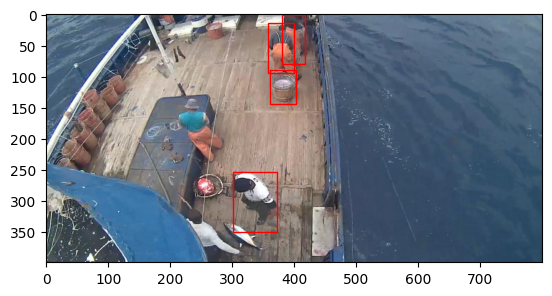

In [210]:
display_bounding_boxes(tensor_transform(image).unsqueeze(0), outputs, thresh=0.9)

In [211]:
def calc_iou(box1: list, box2: list):
    """
    Calculate the intersection over union (IoU) of two bounding boxes.

    Args:
        box1: list of floats (x_min, y_min, x_max, y_max)
        box2: list of floats (x_min, y_min, x_max, y_max)

    Returns:
        float: intersection over union (IoU) between box1 and box2
    """
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # compute the IoU
    iou = intersection_area / union_area

    return iou
    


In [212]:
# Show all model layers
for name, param in model.named_parameters():
    print(name, param.size())

backbone.body.conv1.weight torch.Size([64, 3, 7, 7])
backbone.body.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
backbone.body.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
backbone.body.layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.2.conv1.weight torch.Size([64, 256, 1, 1])
backbone.body.layer1.2.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.2.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer2.0.conv1.weight torch.Size([128, 256, 1, 1])
backbone.body.layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
backbone.body.layer2.0.conv3.weight torch.Size([512, 128, 1, 1])
backbone.body.layer2.0.downsample.0.weight torch.Size([512, 256, 1, 1])
backbone.body.layer2.1.conv1.weight t

In [213]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# # Freeze all model parameters
# for param in model.parameters():
#     param.requires_grad = False

# Replace the box predictor (classifier head)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 26  # Update this if you have a different number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load your saved model weights for CPU
path_to_saved_weights = '../data/best_model.pth'  # Update this path
model.load_state_dict(torch.load(path_to_saved_weights, map_location=torch.device('cpu')))

# Your model is now ready to be used with the updated weights and box predictor
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [214]:
def filter_outputs_by_threshold(outputs, threshold):
    filtered_outputs = []
    for output in outputs:
        # Apply threshold to 'scores' and filter 'boxes' and 'labels' accordingly
        keep = output['scores'] > threshold
        filtered_output = {key: value[keep] for key, value in output.items()}
        filtered_outputs.append(filtered_output)
    return filtered_outputs

def combine_outputs(outputs1, outputs2):
    combined_outputs = []
    for output1, output2 in zip(outputs1, outputs2):
        # Combine outputs from both models
        combined_output = {key: torch.cat((output1[key], output2[key]), dim=0) for key in output1}
        combined_outputs.append(combined_output)
    return combined_outputs




[{'boxes': tensor([[283.3697, 333.2352, 358.8792, 385.9182]], grad_fn=<IndexBackward0>), 'labels': tensor([2]), 'scores': tensor([0.8613], grad_fn=<IndexBackward0>)}]


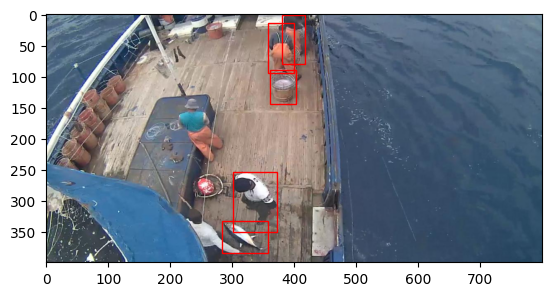

[{'boxes': tensor([[361.3808,  90.2546, 403.0078, 144.5058],
        [301.4160, 254.7201, 372.8805, 350.9529],
        [358.1729,  13.4970, 400.5909,  95.6474],
        [380.9731,   0.9965, 417.7181,  79.6934],
        [283.3697, 333.2352, 358.8792, 385.9182]], grad_fn=<CatBackward0>), 'labels': tensor([47,  1,  1,  1,  2]), 'scores': tensor([0.9831, 0.9729, 0.9504, 0.9099, 0.8613], grad_fn=<CatBackward0>)}]


In [218]:

#resize the image to 400x800 pixels
image = Image.open('../data/test_image_2.jpg')
image = image.resize((800, 400))
normalized_image = tensor_transform(image).unsqueeze(0)
#make new list outputs and new_outputs together
new_outputs = filter_outputs_by_threshold(model(normalized_image),0.4)
combined_outputs = combine_outputs(filter_outputs_by_threshold(outputs,0.9), new_outputs)
print(new_outputs)
display_bounding_boxes(tensor_transform(image).unsqueeze(0),combined_outputs, thresh=0.8)
print(combined_outputs)